# Lesson 3: Reflection and Blogpost Writing

- In this lesson we will learn about agent reflection framework 
- We will also learn how to use Nested Chat Conversation Pattern


## Setup

In [1]:
llm_config = {"model": "gpt-3.5-turbo"}

## The task!

In [2]:
task = '''
        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       '''


## Create a writer agent

In [3]:
import autogen

writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogpost (with title) on given topics. You must polish your "
        "writing based on the feedback you receive and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

In [4]:
reply = writer.generate_reply(messages=[{"content": task, "role": "user"}])

In [5]:
print(reply)

Title: "Exploring the Power of DeepLearning.AI"

Unleash the potential of artificial intelligence with DeepLearning.AI! Founded by Andrew Ng, this platform offers a treasure trove of comprehensive courses on deep learning. From neural networks to natural language processing, DeepLearning.AI equips learners with the skills to thrive in the AI revolution. The interactive online environment and hands-on projects make mastering complex concepts a breeze. Join a global community of learners and dive into the world of deep learning. Whether you're a beginner or an expert, DeepLearning.AI has something to offer everyone in this ever-evolving field. Start your AI journey today!


## Adding reflection 

Create a critic agent to reflect on the work of the writer agent.

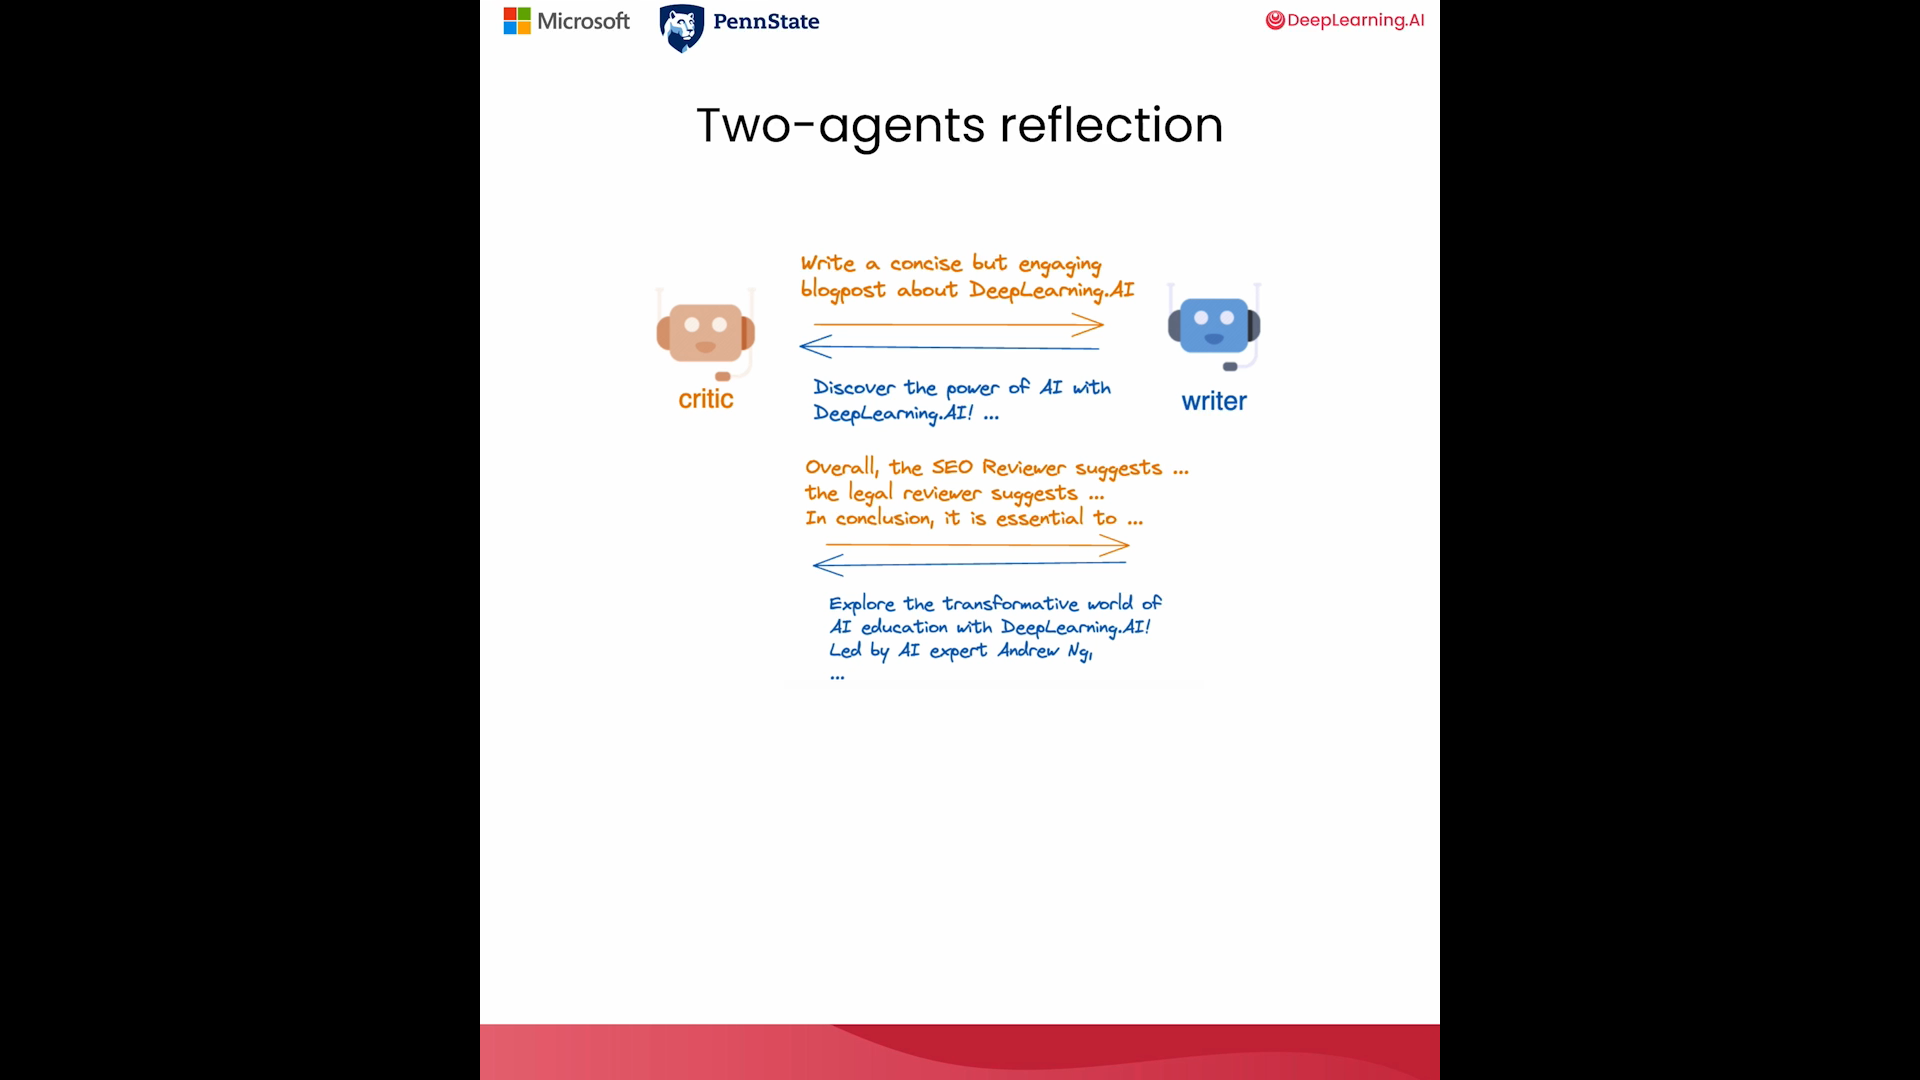

In [6]:
critic = autogen.AssistantAgent(
    name="Critic",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
    system_message="You are a critic. You review the work of "
                "the writer and provide constructive "
                "feedback to help improve the quality of the content.",
)

In [7]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: "Exploring the Power of DeepLearning.AI"

Unleash the potential of artificial intelligence with DeepLearning.AI! Founded by Andrew Ng, this platform offers a treasure trove of comprehensive courses on deep learning. From neural networks to natural language processing, DeepLearning.AI equips learners with the skills to thrive in the AI revolution. The interactive online environment and hands-on projects make mastering complex concepts a breeze. Join a global community of learners and dive into the world of deep learning. Whether you're a beginner or an expert, DeepLearning.AI has something to offer everyone in this ever-evolving field. Start your AI journey today!

------------------------------------------------------------

Since this suggestions provided by critic agent is very general . Lets improve that using Nested Chat . Here we will have multiple reviewers

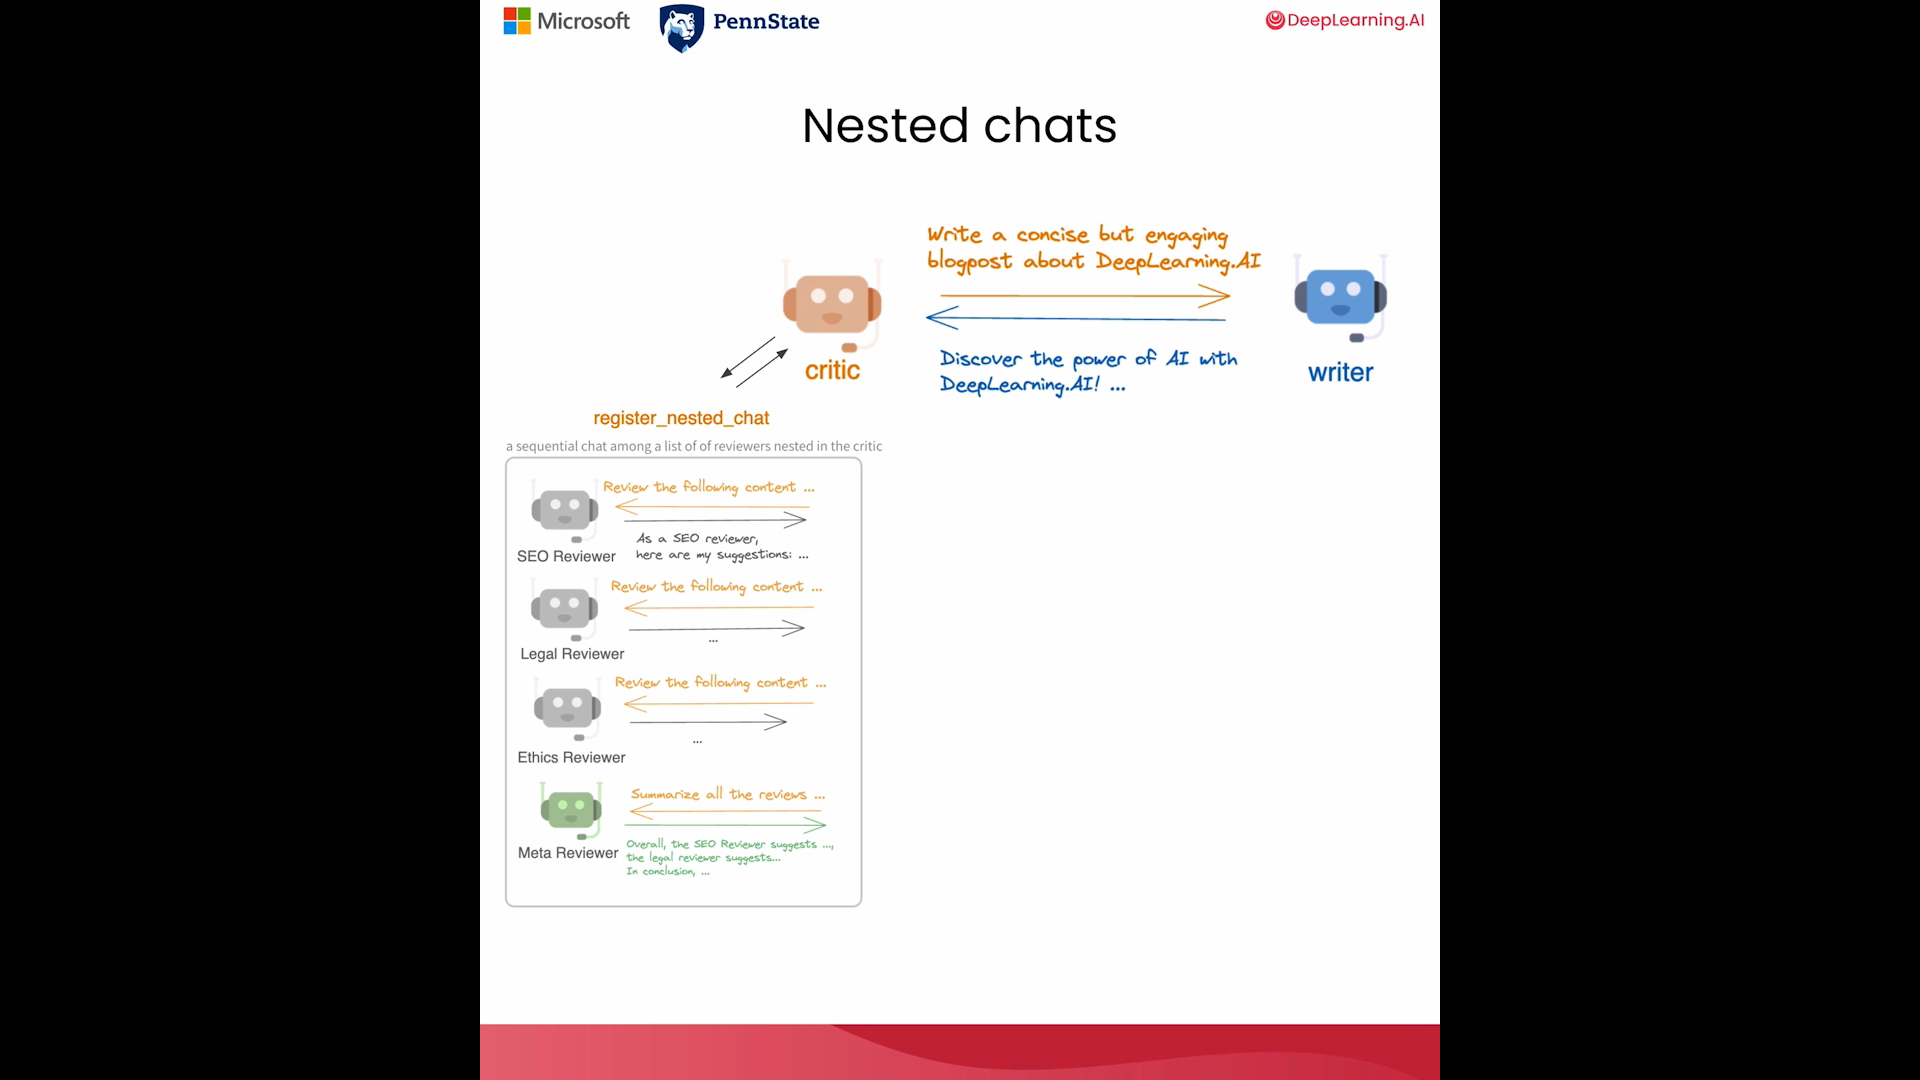

## Nested chat

In [8]:
SEO_reviewer = autogen.AssistantAgent(
    name="SEO Reviewer",
    llm_config=llm_config,
    system_message="You are an SEO reviewer, known for "
        "your ability to optimize content for search engines, "
        "ensuring that it ranks well and attracts organic traffic. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)


In [9]:
legal_reviewer = autogen.AssistantAgent(
    name="Legal Reviewer",
    llm_config=llm_config,
    system_message="You are a legal reviewer, known for "
        "your ability to ensure that content is legally compliant "
        "and free from any potential legal issues. "
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

In [10]:
ethics_reviewer = autogen.AssistantAgent(
    name="Ethics Reviewer",
    llm_config=llm_config,
    system_message="You are an ethics reviewer, known for "
        "your ability to ensure that content is ethically sound "
        "and free from any potential ethical issues. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

In [11]:
meta_reviewer = autogen.AssistantAgent(
    name="Meta Reviewer",
    llm_config=llm_config,
    system_message="You are a meta reviewer, you aggragate and review "
    "the work of other reviewers and give a final suggestion on the content.",
)

## Orchestrate the nested chats to solve the task

In [16]:
def reflection_message(recipient, messages, sender, config):
    return f'''Review the following content. 
            \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}'''

### Here critic agent will be used as center by default in this nested chats. We dont have to define it seperately

review_chats = [
    {
     "recipient": SEO_reviewer, 
    ## We will have to setup inital message properly , SO that nested reviewers can get the content to be reviewe
    ## So we will gather the content from the summary of auto chat session generated above
    ## Thats why we have defined reflection_message in below line to get the content for nested reviewers
        
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}. Here Reviewer should be your role",},
     "max_turns": 1},
    {
    "recipient": legal_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}.",},
     "max_turns": 1},
    {"recipient": ethics_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'reviewer': '', 'review': ''}",},
     "max_turns": 1},
     {"recipient": meta_reviewer, 
      "message": "Aggregrate feedback from all reviewers and give final suggestions on the writing.", 
     "max_turns": 1},
]


In [17]:
critic.register_nested_chats(
    review_chats,
    trigger=writer,
)

**Note**: You might get a slightly different response than what's shown in the video. Feel free to try different task.

In [18]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: "Exploring the Power of DeepLearning.AI"

Unleash the potential of artificial intelligence with DeepLearning.AI! Founded by Andrew Ng, this platform offers a treasure trove of comprehensive courses on deep learning. From neural networks to natural language processing, DeepLearning.AI equips learners with the skills to thrive in the AI revolution. The interactive online environment and hands-on projects make mastering complex concepts a breeze. Join a global community of learners and dive into the world of deep learning. Whether you're a beginner or an expert, DeepLearning.AI has something to offer everyone in this ever-evolving field. Start your AI journey today!

------------------------------------------------------------


--------------------------------------------------------------------------------
Critic (to Writer):

Aggregrate Feedback:
1. SEO Reviewer: Emphasized on optimizing the title for search, including keywords throughout the content, and adding a clear call-to-action for user engagement.
2. Ethics Reviewer: Focused on ensuring the content avoids promoting unrealistic expectations or exploiting fears, verifying claims with evidence, and emphasizing inclusivity and respect for diverse perspectives in the community.

Final Suggestions:
1. Title Optimization: Prioritize optimizing the title for search by including relevant keywords to improve visibility and searchability.
2. Keyword Inclusion: Integrate keywords strategically throughout the content to enhance SEO and provide more context to the topic.
3. Call-to-Action: Implement a clear call-to-action to encourage user engagement and guide them on the next steps.
4. Ethics Compliance: Verify all claims with evidence, ensure community inclusi

## Get the summary

In [19]:
print(res.summary)

Title: "Empowering Your Journey with DeepLearning.AI"

Step into the world of AI mastery with DeepLearning.AI, crafted by renowned expert Andrew Ng. Delve into cutting-edge deep learning techniques through interactive courses. From neural networks to NLP, unlock your potential in the AI landscape. Join a global community of diverse learners for a collaborative learning experience. Let’s embark on this transformative journey together. Embrace the AI revolution – start with DeepLearning.AI today!
